**[Implementation of Real-time Scene Text Detection with Differentiable Binarization](https://arxiv.org/pdf/1911.08947.pdf) with [FPGM Pruning](https://arxiv.org/pdf/1811.00250.pdf)**

**Tangentially Related Papers Worth Reading:** [DeformableConvNets](https://arxiv.org/pdf/1703.06211v3.pdf), [Deformable ConvNets v2](https://arxiv.org/pdf/1811.11168.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Environment Path Constants you can change
DATASET_PATH = './datasets/'
CHECKPOINT_PATH = './checkpoints/DBNet/'
OUTPUT_PATH = './outputs/DBNet'
DATASET = 'SynthText'

# Data Loading Constants
BATCH_SIZE = 200
NUM_WORKERS = 10
PIN_MEMORY = True

# Training Constants
BATCH_PRINT = 50
EPOCH_CHECKPOINT = 10
NUM_EPOCHS = 1000
IS_TRAINING = True

# Device Setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True

print(f'Device: {device}')
print(f'CPU Count: {os.cpu_count()}')
print(f'Number of DataLoading Workers: {NUM_WORKERS}')
print(f'Batch Size: {BATCH_SIZE}')

Device: cuda:0
CPU Count: 20
Number of DataLoading Workers: 10
Batch Size: 200


## Data Loading

Will be Using the Pre-Generated 800K Sample SynthText Dataset to pretrain our model.

**Reference:** [SynthText GitHub](https://github.com/ankush-me/SynthText), [Pre-Generated SynthText](https://www.robots.ox.ac.uk/~vgg/data/scenetext/)

In [2]:
from dataset import SynthText
import torchvision.transforms as transforms
from torchvision.utils import make_grid

def show(x, title=''):
    """ Display a grid from a batched pytorch tensor.
    """
    plt.figure(frameon=False)
    img = make_grid(x)
    npimg = img.numpy()
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')    

transform = transforms.Compose([
    transforms.ToTensor()
])

synth_text = SynthText(f'{DATASET_PATH}{DATASET}', transform=transform)

In [3]:
from torch.utils.data import DataLoader

# Have to define a collate_fn since this is a custom dataset with non-homogenous dimensions per sample.
def collate_fn(batch):
    
    return

synth_loader = DataLoader(synth_text, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)

In [4]:
x = next(iter(synth_loader))[0][:8]
show(img)

TypeError: 'NoneType' object is not subscriptable

## Label Generation

Need to convert bounding box labels from our dataset to ground truth probability maps and threshold maps in order to train our model. ( This is a segmentation based text detector not regression )

Using Vatti clipping algorithm where the offset D is:

$D = \dfrac{A(1-r^{2})}{L}$, $A$ is the area and $L$ is the perimeter of the original polygon

and $r$ is the shrink ratio, set to 0.4 empirically.

The probability map is dilated by -D to shrink it which will represent the label.

The threshold map is slightly trickier. Here we calculate the dilated bounding box then subtract the probability map from it in order to get a binary map
of pixels which represent the gap as mentioned in the paper. Afterwards, we calculate the distance for each pixel in this gap relative to every segment and select the smallest value.


**Reference:** [Vatti Polygon Clipping](http://what-when-how.com/computer-graphics-and-geometric-modeling/clipping-basic-computer-graphics-part-5/), [PyClipper](http://www.angusj.com/delphi/clipper/documentation/Docs/Overview/_Body.htm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


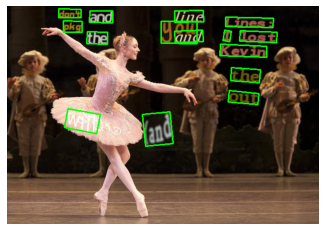

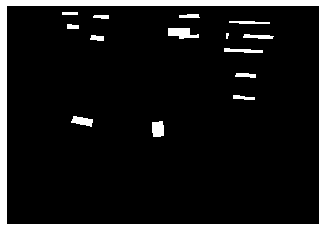

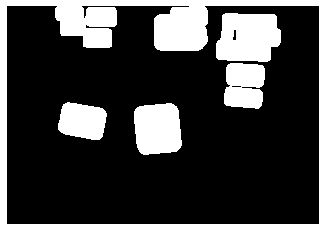

In [154]:
import pyclipper
import cv2

def plot_bb(x, bbox):
    c,h,w = x.shape
    m,n,o = bbox.shape
    x = (x*255).numpy().astype(np.uint8)
    x = np.transpose(x, (1,2,0)).copy()
    subjects = []
    for i in range(o):
        bb = []
        for j in range(n):
            # Clockwise (x,y) -> (r,c) y coordinate flipped
            point = [int(bbox[0][j][i]), int(bbox[1][j][i])]
            bb.append(point)
        subjects.append(np.array(bb, dtype=np.int32))
        
    # Note: CV2 operates as (R,C,CH)
    x = cv2.polylines(x, subjects, True, (0,255,0), 2)
    plt.figure(frameon=False); plt.axis('off')
    plt.imshow(x)
    

def shrink_ratio(box, ratio=0.4):
    # Assume box has clockwise coordinates
    area = cv2.contourArea(np.array(box))
    perimeter = sum([ np.sqrt(((box[i-1] - box[i])**2).sum()) for i in range(1,len(box))])
    return area*(1-ratio**2) / perimeter

def gen_label(x, bbox):
    c,h,w = x.shape
    m,n,o = bbox.shape
    pco = pyclipper.PyclipperOffset()
    subjects = []
    p_map = np.transpose(np.zeros_like(x),(1,2,0)).copy() # This copy() is a hack.
    t_map = np.transpose(np.zeros_like(x),(1,2,0)).copy() # This copy() is a hack.

    for i in range(o):
        bb = []
        
        # Extract bounding box coordinates
        for j in range(n):
            # Clockwise (x,y) -> (r,c) y coordinate flipped
            point = [int(bbox[0][j][i]), int(bbox[1][j][i])]
            bb.append(np.array(point))
            
            pco.AddPath(bb, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
            
        subjects.append(np.array(bb, dtype=np.int32))
        D = shrink_ratio(bb)
        
        # Construct Probability Map Label
        bb_shrink = pco.Execute(-D)
        p_map = cv2.fillPoly(p_map, [np.array(bb_shrink, dtype=np.int32)], (255,255,255))

        # Construct Threshold Map Label
        solution = pco.Execute(D)
        gap = np.transpose(np.zeros_like(x),(1,2,0)).copy()
        gap = cv2.fillPoly(gap, [np.array(solution, dtype=np.int32)], color=(255,255,255)) - p_map
        mg,ng,_ = gap.shape
        
        ## Calculate distance of points in gap to original bounding box segments.
        for k in range(mg):
            for l in range(ng):
                
        
        # Clear the pco for next bb
        pco.Clear()
        
    
    return p_map, t_map

x,word_bb,_,_ = next(iter(synth_text))
plot_bb(x,word_bb)
prob_map, thresh_map = gen_label(x, word_bb)

plt.figure(); plt.axis('off')
plt.imshow(prob_map, interpolation='nearest')

plt.figure(); plt.axis('off')
plt.imshow(thresh_map, interpolation='nearest')


## Differentiable Binarization

$B_{i,j} = \dfrac{1}{1 + e^{-k(P_{i,j} - T_{i,j})}}$, where $k$ is an amplifying factor that is set to 50 empircally, $P_{i,j}$ is the probability map and $T_{i,j}$ is the threshold map.

In [13]:
class DifferentiableBinarization(nn.Module):
    def __init__(self, k):
        super(DifferentiableBinarization, self).__init__()
        self.k = k
        
    def forward(self, x, p, t):
        return x

## Backbone Architectures

## Model Definition
![Figure 3 from Paper](./images/dbnet_arch.png)

## Training

## FPGM Pruning